In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import utils
import math
from imblearn.over_sampling import RandomOverSampler
import cv2
import os

In [2]:
path = "../germany_dataset/train.csv"
dir = '../germany_dataset'
df = pd.read_csv(path)
df = df.dropna()

In [3]:
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,length,height
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,17,15
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,18,16
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,18,16
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,18,16
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,18,16


In [4]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,length,height
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390,39.197786,38.765998
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238,21.821369,20.828697
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000,15.000000,15.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000,24.000000,24.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000,33.000000,32.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000,47.000000,47.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000,203.000000,185.000000


In [5]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = "../germany_dataset/"
testdir = "../germany_dataset/test.csv"
Epochs=1000
train_length = len(df)
Y_col_name="ClassId"

In [6]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  39209


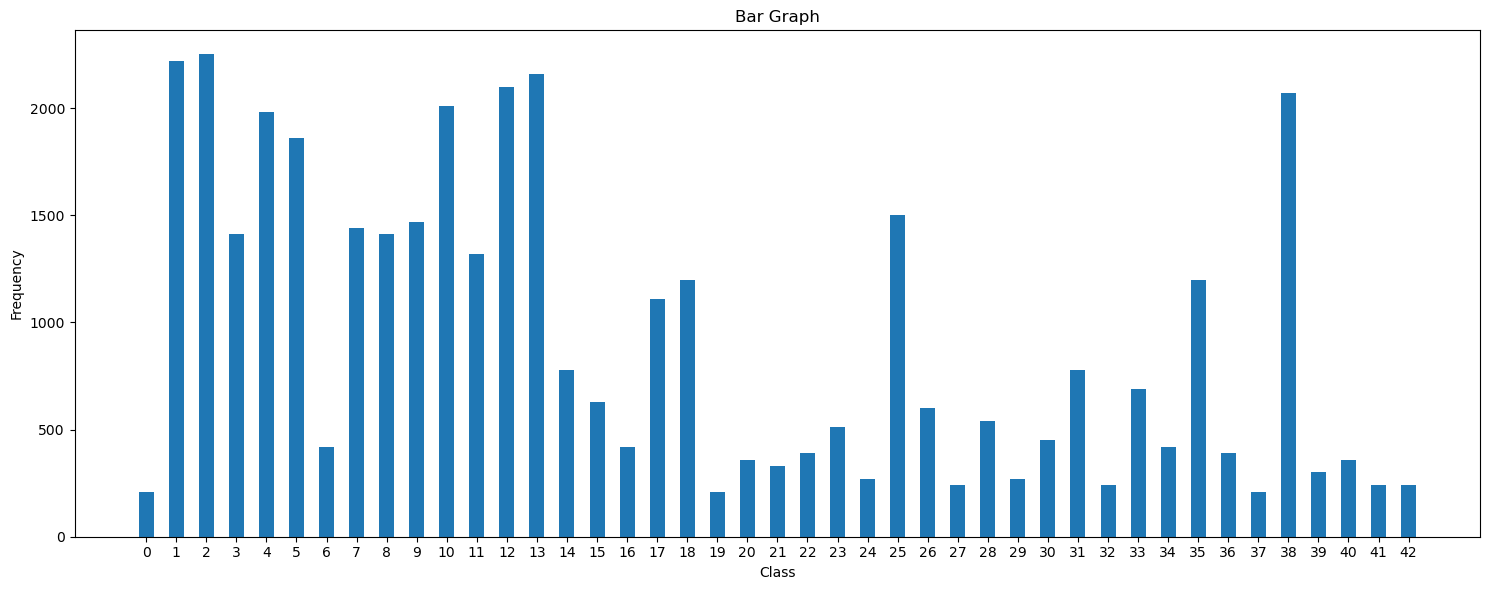

In [7]:
#Statistics of Data
viewStatistics(df)

In [8]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


Total Training Examples :  96750


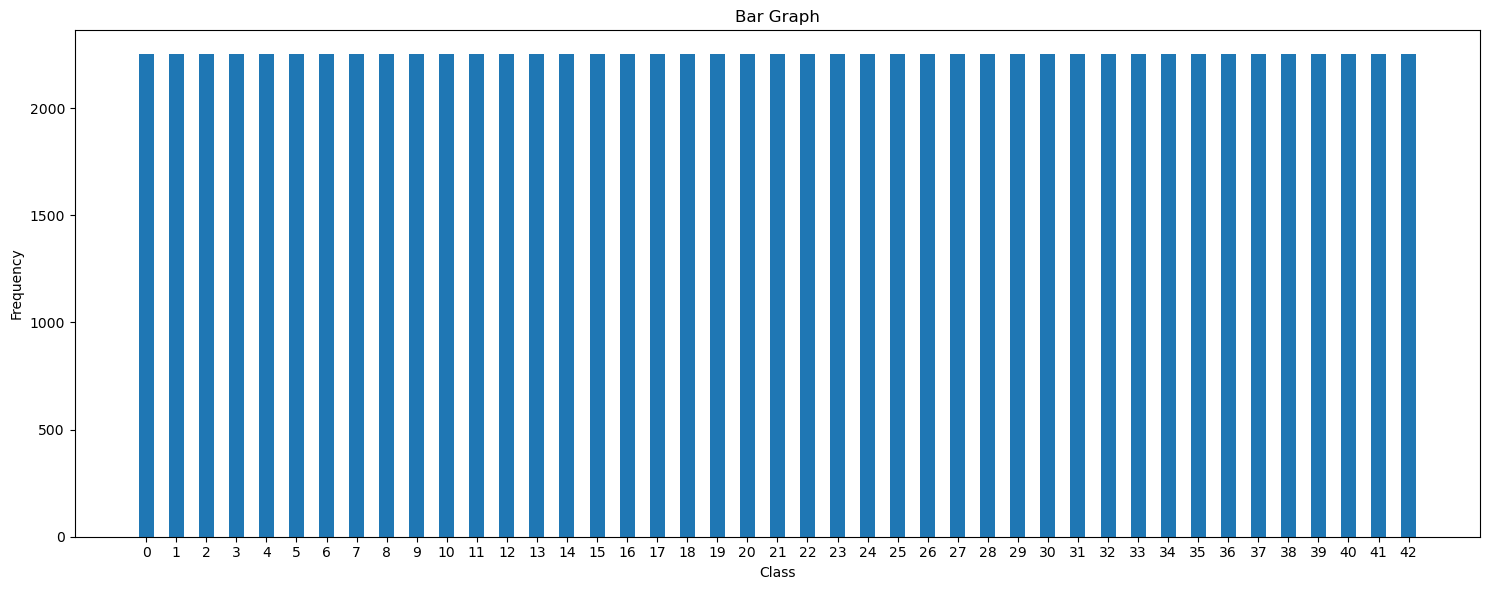

In [9]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled

viewStatistics(df)

In [10]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [11]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer])
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val["Path"])
        ax.imshow(img)
        img = img.crop((val["Roi.X1"],val["Roi.Y1"],val["Roi.X2"],val["Roi.Y2"]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+ str(val["ClassId"]))
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer])
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val["Path"])
        ax.imshow(img)
        img = img.crop((val["Roi.X1"],val["Roi.Y1"],val["Roi.X2"],val["Roi.Y2"]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+ str(val["ClassId"]))
    ax.axis('off')
    

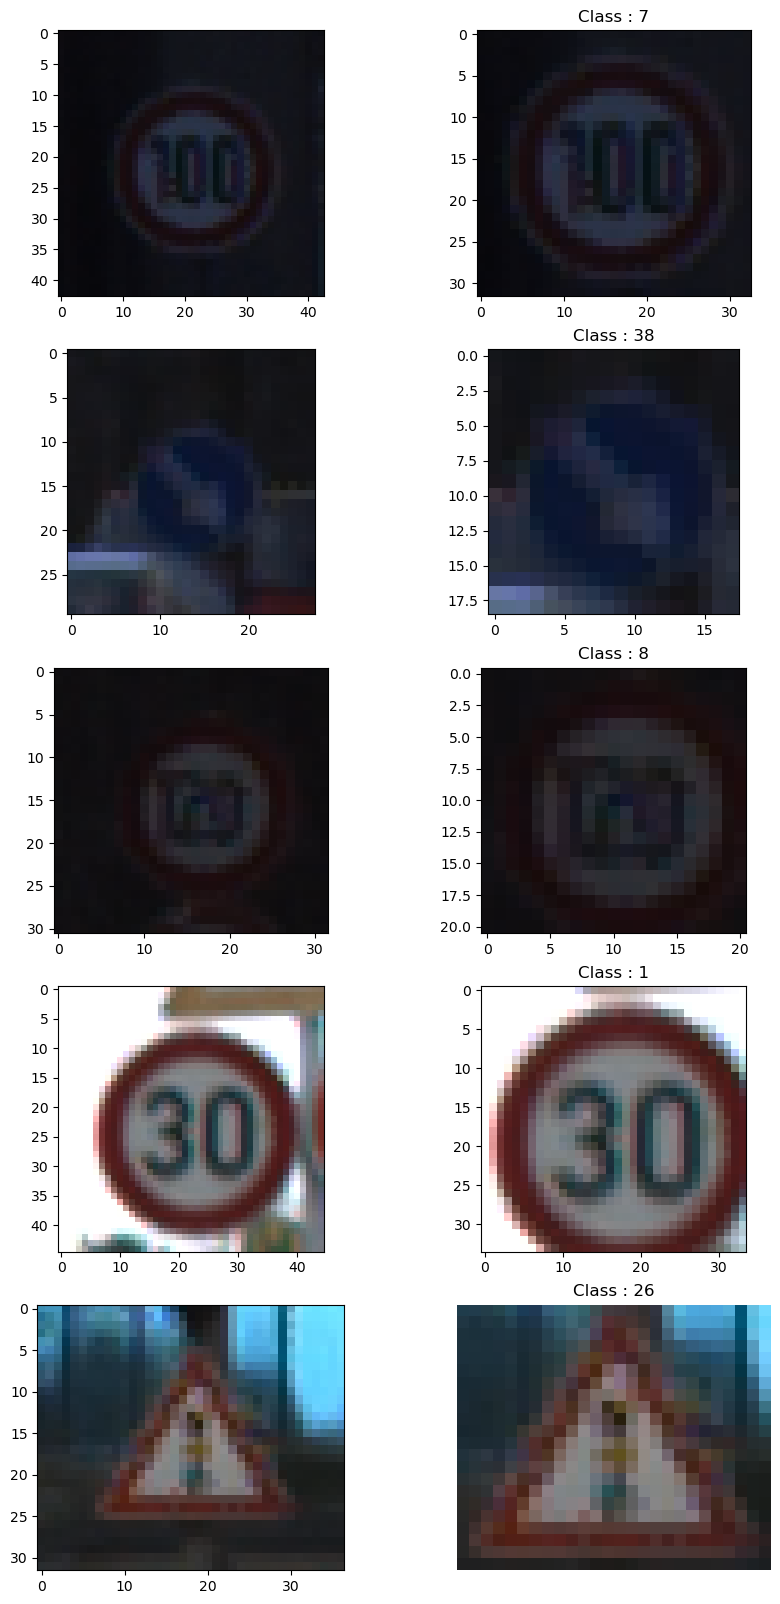

In [12]:
showExamples(df)

In [15]:
print(df["ClassId"].dtype)

int64


In [16]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,length,height,ClassId
0,27,26,5,5,22,20,Train/20/00020_00000_00000.png,17,15,20
1,28,27,5,6,23,22,Train/20/00020_00000_00001.png,18,16,20
2,29,26,6,5,24,21,Train/20/00020_00000_00002.png,18,16,20
3,28,27,5,6,23,22,Train/20/00020_00000_00003.png,18,16,20
4,28,26,5,5,23,21,Train/20/00020_00000_00004.png,18,16,20


In [43]:
def preprocess(image, target_height=resize_x, target_width=resize_y):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])        
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row["Path"]
        image = Image.open(directory+filename)
        images.append(preprocess(image))
        labels.append(row["ClassId"])
        image.close()
    return mixing(images, labels)

def load_test(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row["Path"]
        image = Image.open(directory+filename)
        images.append(preprocess(image))
        labels.append(row["ClassId"])
        image.close()
    return mixing(images, labels)

In [53]:
start = time.time()

train_images, train_labels = load_train(df[:20])
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.

train_labels = utils.to_categorical(train_labels, 43)

print('Loading: ', time.time() - start)

NameError: name 'df_test' is not defined

In [54]:
classes = 43
batch = 256
epochs = 25
learning_rate = 0.0001

def results(model):
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_images, train_labels, batch_size=batch, epochs=25, validation_split=0.2, shuffle = True, verbose=1)
    train_time = time.time() - start
    model.summary()
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 2.8370 - accuracy: 0.0000e+00 - val_loss: 2.1774 - val_accuracy: 1.0000
Epoch 2/25
1/1 [==============================] - 1s 876ms/step - loss: 1.9341 - accuracy: 0.8750 - val_loss: 0.8504 - val_accuracy: 1.0000
Epoch 3/25
1/1 [==============================] - 1s 880ms/step - loss: 1.2469 - accuracy: 0.8750 - val_loss: 0.5617 - val_accuracy: 1.0000
Epoch 4/25
1/1 [==============================] - 1s 896ms/step - loss: 0.5494 - accuracy: 1.0000 - val_loss: 0.2599 - val_accuracy: 1.0000
Epoch 5/25
1/1 [==============================] - 1s 900ms/step - loss: 0.2465 - accuracy: 1.0000 - val_loss: 0.1133 - val_accuracy: 1.0000
Epoch 6/25
1/1 [==============================] - 1s 890ms/step - loss: 0.1079 - accuracy: 1.0000 - val_loss: 0.0510 - val_accuracy: 1.0000
Epoch 7/25
1/1 [==============================] - 1s 877ms/step - loss: 0.0496 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 8/25
1/1 [===

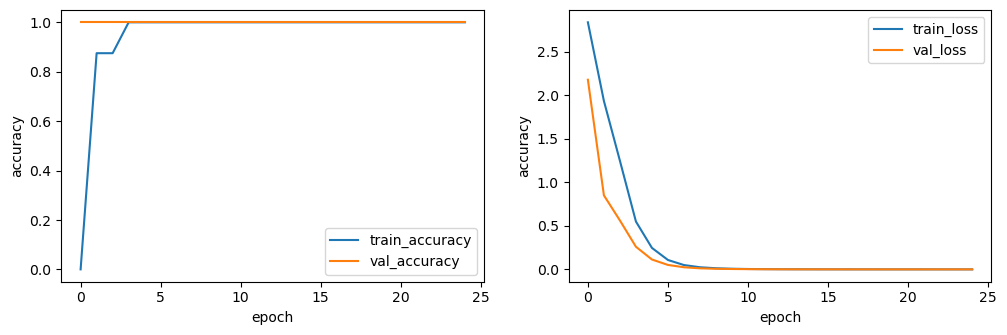

In [55]:
model = models.Sequential()
model.add(VGG19(weights=None, include_top=False, input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='sigmoid'))
model.add(layers.Dense(43, activation='softmax'))

results(model)

 ***Test Image Classification and Accuracy Calculation***

In [56]:
df_test = pd.read_csv(testdir)
df_test["ClassId"] =df_test["ClassId"].astype(str)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Total Training Examples :  12630


C:\Users\gajul\AppData\Local\Temp\ipykernel_7504\983189576.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_labels.append(values[x])


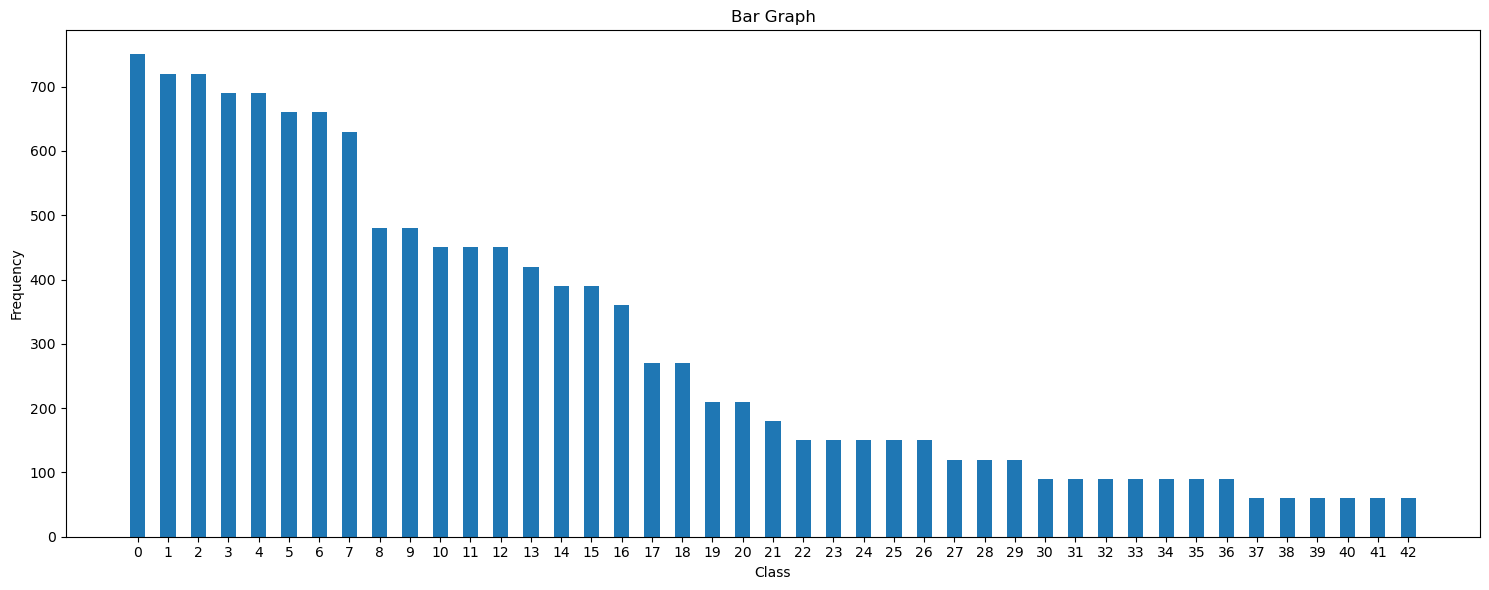

In [57]:
viewStatistics(df_test)

In [58]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


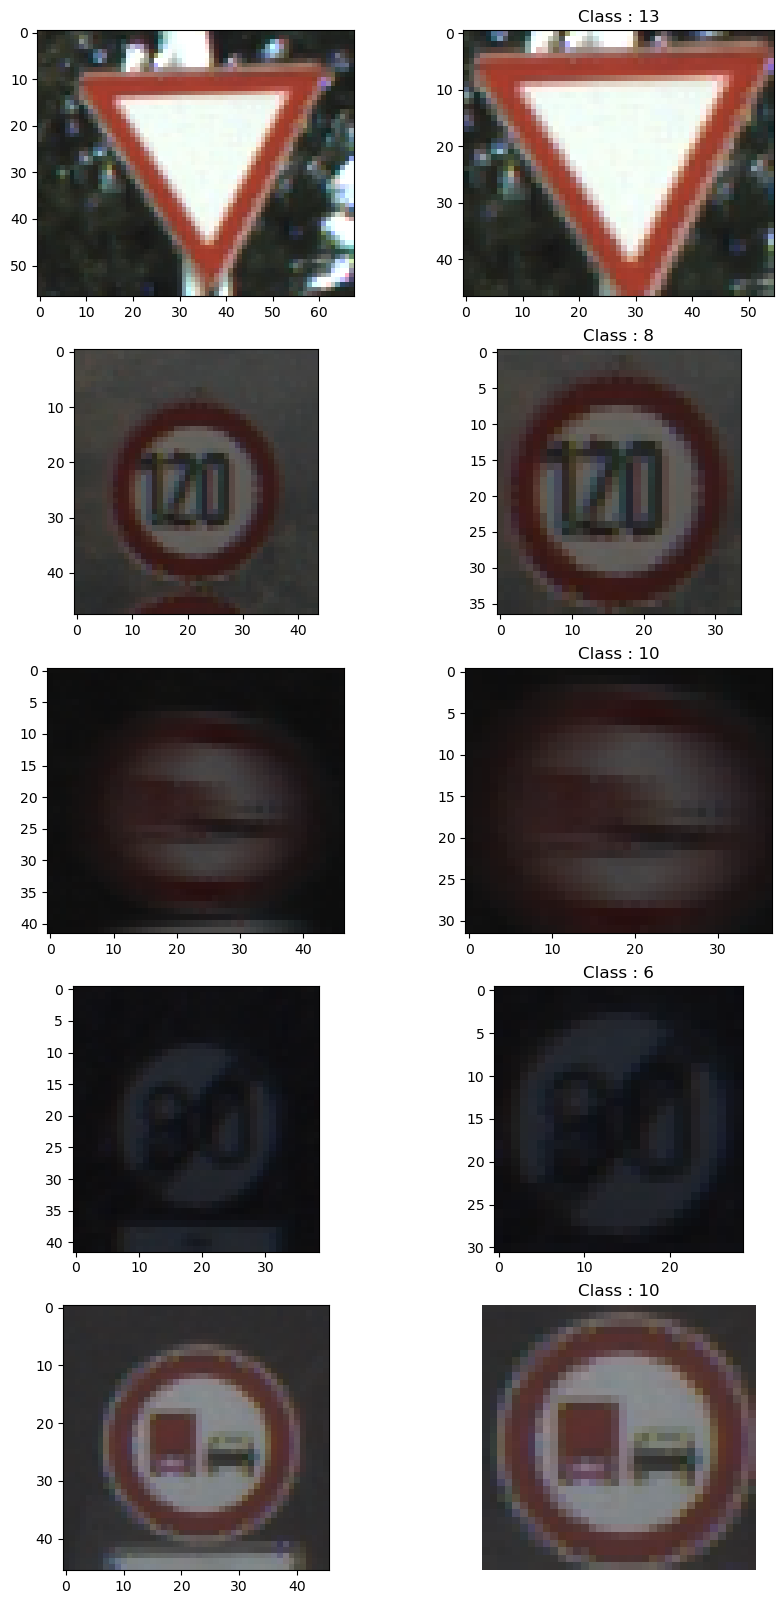

In [59]:
showTestExamples(df_test)

In [60]:
X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [61]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Path,ClassId
0,53,54,6,5,48,49,Test/00000.png,16
1,42,45,5,5,36,40,Test/00001.png,1
2,48,52,6,6,43,47,Test/00002.png,38
3,27,29,5,5,22,24,Test/00003.png,33
4,60,57,5,5,55,52,Test/00004.png,11


In [75]:
test_images,test_labels = load_test(df_test)
test_images = test_images.astype('float32') / 255.
test_labels = test_labels.astype('int')

In [76]:
pred = model.predict(test_images)
y_pred = np.argmax(pred, axis=1)

4/4 [==============================] - 1s 144ms/step


In [77]:
print(y_pred)
print(test_labels)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20]
[ 4 38  9  9 26  1 28 35  7 25 35 16 35 16 13  7 38  1 32  7 24 23 25 12
 12  2 38  5  9  3 25 23 25 38  4 14 34  8  1 18  4  3 27 18 21  3 17  2
 10 12  7 11  3 22 13 13 25 11 11 12 30 30 33 33  9 10 10 12  9 33 15 18
 25 38  5 34 10  1  3 11  3 10  2  9 12 25 17  9  7  5 26 16 20 13 21  9
 33  8 15  5]


In [86]:
confusion = confusion_matrix(test_labels, y_pred)
# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(test_labels, y_pred, labels=np.unique([x for x in range(num_of_classes)]))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  0.01

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



 Summarizing the results : 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_cla

,Class,Precision,Recall,F1-Score,Support
0,0,0.00,0.0,0.00,0
1,1,0.00,0.0,0.00,4
2,2,0.00,0.0,0.00,3
3,3,0.00,0.0,0.00,6
4,4,0.00,0.0,0.00,3
5,5,0.00,0.0,0.00,4
6,6,0.00,0.0,0.00,0
7,7,0.00,0.0,0.00,5
8,8,0.00,0.0,0.00,2
9,9,0.00,0.0,0.00,8


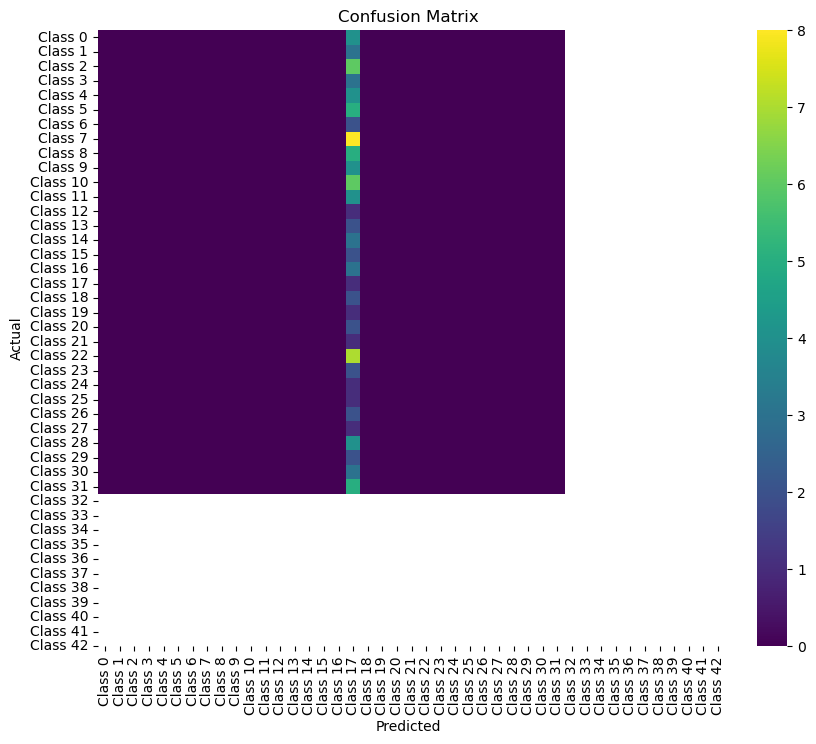

In [87]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()